In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

In [41]:
def lorentzian_func(x, x0, a, gamma):
    return a*gamma/np.pi/2/((x-x0)**2 + (gamma/2)**2)

def parse_file(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    data = []
    for line in lines: # skip to the line that contains the first value
        line = line.replace("\n", "").split('\t')
        data.append(line)
    return data

def px2wavelength(mono):
    gd=1200#grating density[groves/mm]
    cs=2048#chip size
    ps=14e-3#pixel spacing [mm]
    c1 = np.radians(10.63*2)/2
    a = np.arcsin((mono*gd*1e-6)/(np.cos(c1)*2)) - c1
    b = a + np.radians(10.63*2) + np.radians(-5.5)
    h = np.sin(np.radians(-5.5))*318.719
    l = np.cos(np.radians(-5.5))*318.719
    arr = np.zeros(cs)
    for i in range(cs):
        m = b-np.arctan(((((cs/2)-i+1)*ps)+h)/l)
        arr[i] = (np.sin(m)+np.sin(a))*(1000000/gd)
    return arr

In [9]:
dirPath = "D:/Academic/URI/Research/Data_and_Results/experimental_data/2024/CARS/"
dirs = os.listdir(dirPath)
files = [ file for file in os.listdir(dirPath+"/"+dirs[0]) if file.count("_")==1]
filePath = dirPath+"/"+dirs[2]+"/"+files[0]
data = np.loadtxt(filePath)
td_exp = data[:,0]
sig_exp = data[:,1]
sig_exp_log = np.log(sig_exp)-np.min(np.log(sig_exp))

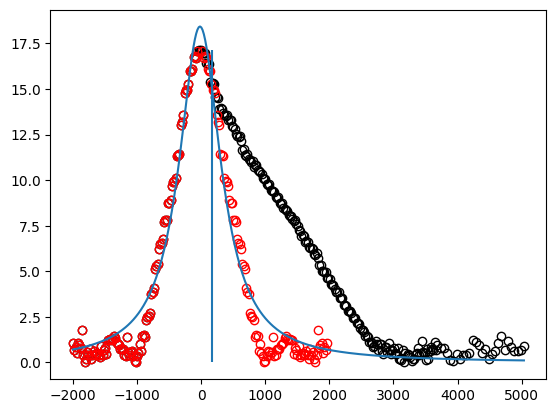

In [10]:
plt.plot(td_exp, sig_exp_log, 'ko', mfc='none')

#lorentzian fit
td_exp_fit = td_exp[td_exp<td_exp[sig_exp_log==np.max(sig_exp_log)][0]]
sig_exp_log_fit = sig_exp_log[td_exp<td_exp[sig_exp_log==np.max(sig_exp_log)][0]]
td_exp_fit = np.append(td_exp_fit, td_exp[sig_exp_log==np.max(sig_exp_log)][0] - np.flip(td_exp_fit))
sig_exp_log_fit = np.append(sig_exp_log_fit, np.flip(sig_exp_log_fit))
plt.plot(td_exp_fit, sig_exp_log_fit, 'ro', mfc='none')

popt, pcov = curve_fit(lorentzian_func,td_exp_fit, sig_exp_log_fit)
plt.plot(td_exp, lorentzian_func(td_exp, *popt))

sig_lor_diff = np.append(np.diff(sig_exp_log-lorentzian_func(td_exp, *popt)),0)
inf_pt = (td_exp[(td_exp<1000) & (td_exp>0)])[sig_lor_diff[(td_exp<1000) & (td_exp>0)]==np.max(sig_lor_diff[(td_exp<1000) & (td_exp>0)])]
plt.vlines(inf_pt[0],0,np.max(sig_exp_log))


In [50]:
dirPath = "D:/Academic/URI/Research/Data_and_Results/experimental_data/2024/CARS/"
dirs = os.listdir(dirPath)

for dir in dirs:#[0:1]:
    files = [file for file in os.listdir(dirPath+dir) if not ("Notes" in file or "Floor" in file or "Spectra" in file)]
    for file in files:#[0:1]:
        filePath = dirPath+dir+"/"+file
        data = np.loadtxt(filePath)
        td_exp = data[:,0]
        sig_exp = data[:,1]
        sig_exp_log = np.log(sig_exp)-np.min(np.log(sig_exp))
        notes_data = {note[0]: note[1] for note in parse_file(filePath.split('.')[0]+"_Notes.dat")}
        w12 = (1e7/float(notes_data['OPO1'])-1e7/float(notes_data['OPO2']))

        fig= plt.figure(figsize=(10,6))
        ######################################## SPECTRA #############################################
        plt.subplot(222)
        spectra_data = np.loadtxt(filePath.split('.')[0]+"_Spectra.dat")
        floor_data = np.loadtxt(filePath.split('.')[0]+"_Floor.dat")
        spectra_td = spectra_data[:,0]
        spectra_sig = spectra_data[:,2:]
        att = spectra_data[:,1]
        floor_idx = np.array([0])
        wl = px2wavelength(float(notes_data['MONO']))
        j = 0
        for i in range(len(att)):
            if not i==0:
                if att[i-1] != att[i]:
                    j+=1
                floor_idx = np.append(floor_idx, j)
        for td in [0, 500, 1000]:
            idx = np.where(spectra_td[spectra_td>=td][0]==spectra_td)[0][0]
            cond_sig = (spectra_sig[idx,:]-floor_data[floor_idx[idx],:])*att[idx]
            plt.plot(1e7/wl-1e7/float(notes_data['Ti-Sa']), cond_sig, label = r"$t_d$ = "+f"{td} fs")
            plt.yscale('log')
        plt.legend()
        ######################################## NOTES #############################################
        plt.subplot(224)
        plt.Axes.set_axis_off(plt.gca())
        plt.text(0, 1, "file : " + f"/{dir}/{file}")
        plt.text(0, 0.9, r"$\omega_1-\omega_2$ : " + f" {w12:.0f} " + r"$\mathrm{cm^{-1}}$")
        plt.text(0, 0.8, r"$\omega_1$ : " + f" {float(notes_data['OPO1']):.0f} " + r"$\mathrm{nm}$")
        plt.text(0, 0.7, r"$\omega_2$ : " + f" {float(notes_data['OPO2']):.0f} " + r"$\mathrm{nm}$")
        plt.text(0, 0.6, r"$TiS$ : " + f" {float(notes_data['Ti-Sa']):.0f} " + r"$\mathrm{nm}$")
        plt.text(0, 0.5, r"Spectral window (px) : " + f" {notes_data['Spectral window (px)']}")
        if len(notes_data['Other'])<40:
            plt.text(0, 0.4, r"$Notes$ : " + f" {notes_data['Other']}")
        else:
            plt.text(0, 0.4, r"$Notes$ : " + f" {notes_data['Other'][:40]}")
            plt.text(0, 0.35, f" {notes_data['Other'][40:80]}")
            plt.text(0, 0.3, f" {notes_data['Other'][80:]}")
        ######################################## CARS #############################################
        plt.subplot(121)
        plt.plot(td_exp, sig_exp_log, 'ko', mfc='none')
        #lorentzian fit
        try:
            td_exp_fit = td_exp[td_exp<td_exp[sig_exp_log==np.max(sig_exp_log)][0]]
            sig_exp_log_fit = sig_exp_log[td_exp<td_exp[sig_exp_log==np.max(sig_exp_log)][0]]
            td_exp_fit = np.append(td_exp_fit, td_exp[sig_exp_log==np.max(sig_exp_log)][0] - np.flip(td_exp_fit))
            sig_exp_log_fit = np.append(sig_exp_log_fit, np.flip(sig_exp_log_fit))
            plt.plot(td_exp_fit, sig_exp_log_fit, 'ro', mfc='none')

            popt, pcov = curve_fit(lorentzian_func,td_exp_fit, sig_exp_log_fit)
            plt.plot(td_exp, lorentzian_func(td_exp, *popt))

            sig_lor_diff = np.append(np.diff(sig_exp_log-lorentzian_func(td_exp, *popt)),0)
            inf_pt = (td_exp[(td_exp<1000) & (td_exp>0)])[sig_lor_diff[(td_exp<1000) & (td_exp>0)]==np.max(sig_lor_diff[(td_exp<1000) & (td_exp>0)])]
            plt.vlines(inf_pt[0],0,np.max(sig_exp_log))

            plt.tight_layout()
            plt.title(r"$\omega_1-\omega_2$=" + f" {w12:.0f} " + r"$\mathrm{cm^{-1}}$")
            plt.savefig(f"images/{dir}_{file}.png")
        except:
            print(f"{dir}/{file}")
            plt.savefig(f"images/{dir}_{file}.png")
        plt.close()

C:\Users\dinus\AppData\Local\Temp\ipykernel_2164\1821382826.py:11: RuntimeWarning: divide by zero encountered in log
  sig_exp_log = np.log(sig_exp)-np.min(np.log(sig_exp))
C:\Users\dinus\AppData\Local\Temp\ipykernel_2164\1821382826.py:11: RuntimeWarning: invalid value encountered in log
  sig_exp_log = np.log(sig_exp)-np.min(np.log(sig_exp))


Jul_25/NLB_3.dat
Jul_25/NLB_4.dat
Jul_25/NLB_5.dat
Jul_25/NLB_6.dat
Jul_30/LNB_2.dat


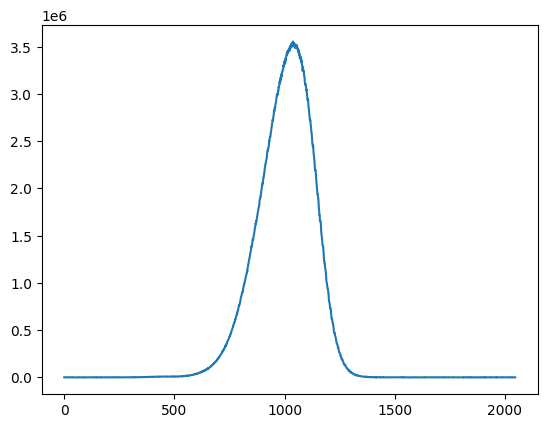

In [ ]:
filePath = "D:/Academic/URI/Research/Data_and_Results/experimental_data/2024/CARS/Aug_01/LNB_1.dat"
spectra_data = np.loadtxt(filePath.split('.')[0]+"_Spectra.dat")
floor_data = np.loadtxt(filePath.split('.')[0]+"_Floor.dat")
spectra_td = spectra_data[:,0]
spectra_sig = spectra_data[:,2:]
att = spectra_data[:,1]
floor_idx = np.array([0])
j = 0
for i in range(len(att)):
    if not i==0:
        if att[i-1] != att[i]:
            j+=1
        floor_idx = np.append(floor_idx, j)
td = 0
idx = np.where(spectra_td[spectra_td>=td][0]==spectra_td)[0][0]
cond_sig = (spectra_sig[idx,:]-floor_data[floor_idx[idx],:])*att[idx]

In [13]:
filePath = "D:/Academic/URI/Research/Data_and_Results/experimental_data/2024/CARS/Aug_01/LNB_1.dat"
notes_data = {note[0]: note[1] for note in parse_file(filePath.split('.')[0]+"_Notes.dat")}
w12 = (1e7/float(notes_data['OPO1'])-1e7/float(notes_data['OPO2']))
notes_data

{'DET': 'Syncerity CCD',
 'SMP': 'LNB',
 'P3 (TiS)': '140',
 'P1 (OPO1)': '16',
 'P2 (OPO2)': '24',
 'Polarizations': 'all parallel',
 'Ti-Sa': '818.4',
 'OPO1': '1018',
 'OPO2': '1108',
 'MONO': '762',
 'Slit': '0.35',
 'ATTN_0 (initial)': '1',
 'SP&BP filters': 'Semrock 790-25x36, 750/50, 793ASP',
 'Spectral bandwidths and distortion': '~10 nm OPO1 ~12 nm OPO1-symm, OPO2-symm',
 'Spectral shift at the end of the measurement': 'NO',
 'Power increase/decrease (>20%) at the end of the measurement': 'NO',
 'Other': '10% px range,OPO2+OPO1=40mW',
 'Spectral window (px)': '730.0 to 1220.0',
 'Version': '4',
 '': ''}